# Brute Force

In [75]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from shapely.ops import transform
import matplotlib.patches as patches
from shapely.geometry import Polygon, box, mapping
from shapely.ops import unary_union
from pyproj import Transformer, CRS
import numpy as np
from typing import List, Tuple
import os

from shapely.affinity import rotate

import plotly.graph_objects as go

import ipywidgets as widgets
from IPython.display import display, HTML

from matplotlib.patches import Polygon as MplPolygon
import time

from shapely.strtree import STRtree
from shapely.prepared import prep
from shapely.strtree import STRtree
from shapely.prepared import prep

import numpy as np
from shapely.geometry import Polygon, box
from shapely.affinity import rotate
from pyproj import CRS, Transformer

from collections import deque
from collections import deque
import numpy as np
from shapely.geometry import box
from shapely.affinity import rotate

from aquarel import load_theme
import matplotlib.style as mplstyle
mplstyle.core.USER_LIBRARY_PATHS.append('/home/kb/anaconda3/envs/myenv/lib/python3.13/site-packages/aquarel/styles')

In [2]:
def extract_polygons_from_kml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    # KML namespace
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}

    polygons = []

    # Find ALL <coordinates> inside ANY <Polygon>
    for coords in root.findall(".//kml:Polygon//kml:coordinates", ns):
        text = coords.text.strip()
        pts = []

        for line in text.split():
            lon, lat, *_ = line.split(',')
            pts.append((float(lon), float(lat)))

        polygons.append(pts)

    return polygons

In [3]:
polygons = extract_polygons_from_kml("valid.kml")
print("Found polygons:", len(polygons))

#for p in polygons:
#    print(p[:3], "...")


Found polygons: 10


In [51]:
def generate_offsets(rect_w = 1, rect_h = 1, w_res = 100, h_res = 100, res_mode = "land"):
    if res_mode == "rect":
        step_w = rect_w / w_res
        step_h = rect_h / h_res
    elif res_mode == "land":
        step_w = 1 / w_res
        step_h = 1 / h_res
    else:
        raise ValueError("Mode not selected")

    offsets = []
    for j in range(h_res):
        for i in range(w_res):
            offsets.append((
                round(i * step_w, 6),
                round(j * step_h, 6)
            ))
    return offsets

In [34]:
def point_in_poly_numpy(xs, ys, poly_xy):
    px = poly_xy[:, 0]
    py = poly_xy[:, 1]

    n = len(px)
    inside = np.zeros(xs.shape, dtype=bool)

    x1 = px
    y1 = py
    x2 = np.roll(px, -1)
    y2 = np.roll(py, -1)

    for i in range(n):
        denom = (y2[i] - y1[i])
        denom = denom if np.abs(denom) > 1e-15 else (1e-15 * np.sign(denom) if denom != 0 else 1e-15)
        cond = ((y1[i] > ys) != (y2[i] > ys)) & (
            xs < ((x2[i] - x1[i]) * (ys - y1[i]) / denom + x1[i])
        )
        inside ^= cond

    return inside


In [35]:
def pack_rectangles_in_polygon_brute_force(
    polygon_lonlat,
    rect_w_m,
    rect_h_m,
    try_offsets,
    w_res=100,
    h_res=100,
    res_mode="land",
    angle_deg=60,
    store_all=False,
    pad_m=0.0,
    Is_Convex=False,
):
    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return []

    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} +units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)
    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_local_coords = np.array([to_local(lon, lat) for lon, lat in polygon_lonlat])
    poly_local = Polygon(poly_local_coords)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return []

    rot_origin = poly_local.centroid
    poly_rot_shp = rotate(poly_local, -angle_deg, origin=rot_origin, use_radians=False)

    if pad_m > 0:
        poly_rot_shp = poly_rot_shp.buffer(-pad_m)
        if poly_rot_shp.is_empty:
            return []

    minx, miny, maxx, maxy = poly_rot_shp.bounds

    if try_offsets == True:
        offsets = generate_offsets(
            rect_w=rect_w_m, rect_h=rect_h_m,
            w_res=w_res, h_res=h_res, res_mode=res_mode
        )
    elif try_offsets == "half":
        offsets = [
            (0,0),(rect_w_m/2,0),(0,rect_h_m/2),(rect_w_m/2,rect_h_m/2)
        ]
    else:
        offsets = [(0,0)]

    best_rects = []
    best_count = -1
    all_rects = []
    cw = rect_w_m
    ch = rect_h_m

    if Is_Convex:
        # -------- FAST 4-CORNER CHECK --------
        poly_rot = np.array(poly_rot_shp.exterior.coords)
        dx = np.array([0, cw, cw, 0])
        dy = np.array([0, 0, ch, ch])

        for ox, oy in offsets:
            xs = np.arange(minx - cw + ox, maxx + cw, cw)
            ys = np.arange(miny - ch + oy, maxy + ch, ch)

            if xs.size == 0 or ys.size == 0:
                continue

            XX, YY = np.meshgrid(xs, ys, indexing="xy")
            base_x = XX.ravel()
            base_y = YY.ravel()

            all_x = base_x[:, None] + dx[None, :]
            all_y = base_y[:, None] + dy[None, :]

            inside = point_in_poly_numpy(all_x, all_y, poly_rot)
            valid_mask = np.all(inside, axis=1)
            valid_idx = np.nonzero(valid_mask)[0]

            rects = []
            for i in valid_idx:
                x0 = base_x[i]
                y0 = base_y[i]
                rects.append(box(x0, y0, x0 + cw, y0 + ch))

            if store_all:
                for i in range(len(base_x)):
                    all_rects.append(box(base_x[i], base_y[i], base_x[i]+cw, base_y[i]+ch))

            if len(rects) > best_count:
                best_count = len(rects)
                best_rects = rects

    else:
        # -------- SLOW COVER CHECK --------
        for ox, oy in offsets:
            start_x = minx - cw
            start_y = miny - ch
            xs = np.arange(start_x + ox, maxx + cw, cw)
            ys = np.arange(start_y + oy, maxy + ch, ch)

            rects = []
            for x in xs:
                for y in ys:
                    candidate = box(x, y, x + cw, y + ch)
                    if store_all:
                        all_rects.append(candidate)
                    if poly_rot_shp.covers(candidate):
                        rects.append(candidate)

            if len(rects) > best_count:
                best_count = len(rects)
                best_rects = rects

    result = []
    centers = []
    all_result = []

    # --- Sort rectangles row-wise instead of column-wise ---
    best_rects = sorted(best_rects, key=lambda r: (r.bounds[1], r.bounds[0])) # (miny, minx)


    for r in best_rects:
        r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
        coords = np.array(r_back.exterior.coords)[:-1]
        coords_ll = [to_wgs84(x,y) for x,y in coords]
        result.append(coords_ll)
        c = r_back.centroid
        centers.append(to_wgs84(c.x, c.y))

    if store_all:
        for r in all_rects:
            r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
            coords = np.array(r_back.exterior.coords)[:-1]
            coords_ll = [to_wgs84(x,y) for x,y in coords]
            all_result.append(coords_ll)
            c = r_back.centroid
            centers.append(to_wgs84(c.x, c.y))

    return result, best_count, best_rects, poly_rot_shp, centers, all_result

In [36]:
def pack_rectangles_in_polygon_brute_force_sliding(
    polygon_lonlat,
    rect_w_m,
    rect_h_m,
    try_offsets,
    w_res=100,
    h_res=100,
    res_mode="land",
    angle_deg=0,
    store_all=False,
    pad_m=0.0,
    Is_Convex=False,
):
    from shapely.geometry import Polygon, box
    from shapely.ops import transform
    from shapely.affinity import rotate
    import numpy as np
    from pyproj import CRS, Transformer

    # -------------------------------
    # 1) Create polygon and local CRS
    # -------------------------------
    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return []

    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} "
        f"+units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)

    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_local_pts = np.array([to_local(lon, lat) for lon, lat in polygon_lonlat])
    poly_local = Polygon(poly_local_pts)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return []

    # -------------------------------
    # 2) Rotate polygon for packing
    # -------------------------------
    rot_origin = poly_local.centroid
    poly_rot = rotate(poly_local, -angle_deg, origin=rot_origin, use_radians=False)

    if pad_m > 0:
        poly_rot = poly_rot.buffer(-pad_m)
        if poly_rot.is_empty:
            return []

    minx, miny, maxx, maxy = poly_rot.bounds
    cw, ch = rect_w_m, rect_h_m

    # -------------------------------
    # 3) Row-based greedy sliding
    # -------------------------------
    placed_rects = []
    all_rects = []

    # Try offsets if needed
    if try_offsets == True:
        offsets = generate_offsets(rect_w=cw, rect_h=ch, w_res=w_res, h_res=h_res, res_mode=res_mode)
    elif try_offsets == "half":
        offsets = [(0, 0), (cw/2, 0), (0, ch/2), (cw/2, ch/2)]
    else:
        offsets = [(0, 0)]

    best_rects = []
    best_count = -1
    best_all_rects = []

    for ox, oy in offsets:

        rects_this_offset = []
        all_rects_this_offset = []

        # Start at first row
        y = miny + oy

        while y <= maxy + ch:

            # --- find leftmost valid "x-start" for this row ---
            x_start = None
            scan_xs = np.linspace(minx - cw, maxx, 400)

            for xs in scan_xs:
                candidate = box(xs, y, xs + cw, y + ch)
                if poly_rot.covers(candidate):
                    x_start = xs
                    break

            if x_start is None:
                y += ch
                continue

            # --- fill row greedily ---
            x = x_start
            while x <= maxx + cw:
                candidate = box(x, y, x + cw, y + ch)

                if store_all:
                    all_rects_this_offset.append(candidate)

                if poly_rot.covers(candidate):
                    rects_this_offset.append(candidate)
                    x += cw
                else:
                    x += cw

            y += ch

        # Pick best among offsets
        if len(rects_this_offset) > best_count:
            best_count = len(rects_this_offset)
            best_rects = rects_this_offset
            best_all_rects = all_rects_this_offset

    # -------------------------------
    # 4) Convert back to WGS84
    # -------------------------------
    best_rects_sorted = sorted(best_rects, key=lambda r: (r.bounds[1], r.bounds[0]))

    result = []
    centers = []
    all_result = []

    for r in best_rects_sorted:
        r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
        coords = np.array(r_back.exterior.coords)[:-1]
        coords_ll = [to_wgs84(x, y) for x, y in coords]
        result.append(coords_ll)

        c = r_back.centroid
        centers.append(to_wgs84(c.x, c.y))

    if store_all:
        for r in best_all_rects:
            r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
            coords = np.array(r_back.exterior.coords)[:-1]
            coords_ll = [to_wgs84(x, y) for x, y in coords]
            all_result.append(coords_ll)

            c = r_back.centroid
            centers.append(to_wgs84(c.x, c.y))

    return result, best_count, best_rects, poly_rot, centers, all_result


In [37]:
def pack_rectangles_in_polygon_brute_force_sliding(
    polygon_lonlat,
    rect_w_m,
    rect_h_m,
    try_offsets,
    w_res=100,
    h_res=100,
    res_mode="land",
    angle_deg=0,
    store_all=False,
    pad_m=0.0,
    Is_Convex=False,
    pitch_distance=0.0
):
    from shapely.geometry import Polygon, box
    from shapely.ops import transform
    from shapely.affinity import rotate
    import numpy as np
    from pyproj import CRS, Transformer

    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return []

    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} "
        f"+units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)

    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_local_pts = np.array([to_local(lon, lat) for lon, lat in polygon_lonlat])
    poly_local = Polygon(poly_local_pts)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return []

    rot_origin = poly_local.centroid
    poly_rot = rotate(poly_local, -angle_deg, origin=rot_origin, use_radians=False)

    if pad_m > 0:
        poly_rot = poly_rot.buffer(-pad_m)
        if poly_rot.is_empty:
            return []

    minx, miny, maxx, maxy = poly_rot.bounds
    cw, ch = rect_w_m, rect_h_m

    if try_offsets == True:
        offsets = generate_offsets(rect_w=cw, rect_h=ch, w_res=w_res, h_res=h_res, res_mode=res_mode)
    elif try_offsets == "half":
        offsets = [(0, 0), (cw/2, 0), (0, ch/2), (cw/2, ch/2)]
    else:
        offsets = [(0, 0)]

    best_rects = []
    best_count = -1
    best_all_rects = []

    for ox, oy in offsets:

        rects_this_offset = []
        all_rects_this_offset = []

        y = miny + oy
        first_row = True

        while y <= maxy + ch:

            x_start = None
            scan_xs = np.linspace(minx - cw, maxx, 400)

            for xs in scan_xs:
                candidate = box(xs, y, xs + cw, y + ch)
                if poly_rot.covers(candidate):
                    x_start = xs
                    break

            if x_start is None:
                if first_row:
                    y += ch
                    first_row = False
                else:
                    y += ch + pitch_distance
                continue

            x = x_start
            while x <= maxx + cw:
                candidate = box(x, y, x + cw, y + ch)

                if store_all:
                    all_rects_this_offset.append(candidate)

                if poly_rot.covers(candidate):
                    rects_this_offset.append(candidate)
                    x += cw
                else:
                    x += cw

            if first_row:
                y += ch
                first_row = False
            else:
                y += ch + pitch_distance

        if len(rects_this_offset) > best_count:
            best_count = len(rects_this_offset)
            best_rects = rects_this_offset
            best_all_rects = all_rects_this_offset

    best_rects_sorted = sorted(best_rects, key=lambda r: (r.bounds[1], r.bounds[0]))

    result = []
    centers = []
    all_result = []

    for r in best_rects_sorted:
        r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
        coords = np.array(r_back.exterior.coords)[:-1]
        coords_ll = [to_wgs84(x, y) for x, y in coords]
        result.append(coords_ll)

        c = r_back.centroid
        centers.append(to_wgs84(c.x, c.y))

    if store_all:
        for r in best_all_rects:
            r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
            coords = np.array(r_back.exterior.coords)[:-1]
            coords_ll = [to_wgs84(x, y) for x, y in coords]
            all_result.append(coords_ll)

            c = r_back.centroid
            centers.append(to_wgs84(c.x, c.y))

    return result, best_count, best_rects, poly_rot, centers, all_result


In [56]:
def pack_rectangles_in_polygon_brute_force_sliding(
    polygon_lonlat,
    rect_w_m,
    rect_h_m,
    try_offsets,
    w_res=100,
    h_res=100,
    res_mode="land",
    angle_deg=0,
    store_all=False,
    pad_m=0.0,
    Is_Convex=False,
    pitch_distance=0.0,
    row_slide_range_m=5.0,
    row_slide_steps=12,
):
    from shapely.geometry import Polygon, box
    from shapely.ops import transform
    from shapely.affinity import rotate
    import numpy as np
    from pyproj import CRS, Transformer

    # -------------------------------
    # 1) Create polygon and local CRS
    # -------------------------------
    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return []

    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} "
        f"+units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)

    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_local_pts = np.array([to_local(lon, lat) for lon, lat in polygon_lonlat])
    poly_local = Polygon(poly_local_pts)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return []

    # -------------------------------
    # 2) Rotate polygon for packing
    # -------------------------------
    rot_origin = poly_local.centroid
    poly_rot = rotate(poly_local, -angle_deg, origin=rot_origin, use_radians=False)

    if pad_m > 0:
        poly_rot = poly_rot.buffer(-pad_m)
        if poly_rot.is_empty:
            return []

    minx, miny, maxx, maxy = poly_rot.bounds
    cw, ch = rect_w_m, rect_h_m

    # -------------------------------
    # 3) Row-based greedy sliding with per-row vertical optimization
    # -------------------------------
    placed_rects = []
    all_rects = []

    # Try offsets if needed
    if try_offsets == True:
        offsets = generate_offsets(rect_w=cw, rect_h=ch, w_res=w_res, h_res=h_res, res_mode=res_mode)
    elif try_offsets == "half":
        offsets = [(0, 0), (cw/2, 0), (0, ch/2), (cw/2, ch/2)]
    else:
        offsets = [(0, 0)]

    best_rects = []
    best_count = -1
    best_all_rects = []

    # precompute scan_xs once (same as before)
    scan_xs = np.linspace(minx - cw, maxx, 400)

    for ox, oy in offsets:

        rects_this_offset = []
        all_rects_this_offset = []

        # Start at first row
        y = miny + oy
        first_row = True

        while y <= maxy + ch:

            # ------------------------------
            # Per-row vertical sliding search
            # ------------------------------
            row_best = []
            row_best_count = -1
            y_optimal = None

            if row_slide_range_m is None:
                y_candidates = np.array([y])
            elif row_slide_range_m <= 0 or row_slide_steps <= 1:
                y_candidates = np.array([y])
            else:
                y_candidates = np.linspace(y - row_slide_range_m, y + row_slide_range_m, row_slide_steps)

            for y_try in y_candidates:

                # find leftmost valid "x-start" for this candidate y
                x_start_try = None
                for xs in scan_xs:
                    candidate = box(xs, y_try, xs + cw, y_try + ch)
                    if poly_rot.covers(candidate):
                        x_start_try = xs
                        break

                if x_start_try is None:
                    continue

                # fill row greedily at y_try
                x = x_start_try
                placed_here = []

                while x <= maxx + cw:
                    candidate = box(x, y_try, x + cw, y_try + ch)

                    # note: avoid appending to global all_rects_this_offset during trial
                    if poly_rot.covers(candidate):
                        placed_here.append(candidate)
                        x += cw
                    else:
                        x += cw

                if len(placed_here) > row_best_count:
                    row_best_count = len(placed_here)
                    row_best = placed_here
                    y_optimal = y_try

            # If we found no placement for any y_try, advance and continue
            if row_best_count <= 0:
                if first_row:
                    y += ch
                    first_row = False
                else:
                    y += ch + pitch_distance
                continue

            # Accept the best row placement found
            rects_this_offset.extend(row_best)
            if store_all:
                # mimic previous behavior: store the fitted rectangles for this offset (at optimal y)
                all_rects_this_offset.extend(row_best)

            # Advance to next row based on chosen y_optimal
            if y_optimal is None:
                # fallback (shouldn't happen because row_best_count>0), but safe
                if first_row:
                    y += ch
                    first_row = False
                else:
                    y += ch + pitch_distance
            else:
                if first_row:
                    y = y_optimal + ch
                    first_row = False
                else:
                    y = y_optimal + ch + pitch_distance

        # Pick best among offsets
        if len(rects_this_offset) > best_count:
            best_count = len(rects_this_offset)
            best_rects = rects_this_offset
            best_all_rects = all_rects_this_offset

    # -------------------------------
    # 4) Convert back to WGS84
    # -------------------------------
    best_rects_sorted = sorted(best_rects, key=lambda r: (r.bounds[1], r.bounds[0]))

    result = []
    centers = []
    all_result = []

    for r in best_rects_sorted:
        r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
        coords = np.array(r_back.exterior.coords)[:-1]
        coords_ll = [to_wgs84(x, y) for x, y in coords]
        result.append(coords_ll)

        c = r_back.centroid
        centers.append(to_wgs84(c.x, c.y))

    if store_all:
        for r in best_all_rects:
            r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
            coords = np.array(r_back.exterior.coords)[:-1]
            coords_ll = [to_wgs84(x, y) for x, y in coords]
            all_result.append(coords_ll)

            c = r_back.centroid
            centers.append(to_wgs84(c.x, c.y))

    return result, best_count, best_rects, poly_rot, centers, all_result


In [73]:
def pack_rectangles_in_polygon_brute_force_sliding(
    polygon_lonlat,
    rect_w_m,
    rect_h_m,
    try_offsets,
    w_res=100,
    h_res=100,
    res_mode="land",
    angle_deg=0,
    store_all=False,
    pad_m=0.0,
    Is_Convex=False,

    # ===== new, clearer attributes =====
    min_pitch_m=2,       # minimum spacing between rows
    max_pitch_m=10,       # maximum spacing between rows
    pitch_step_m=0.5,      # pitch resolution
):
    from shapely.geometry import Polygon, box
    from shapely.ops import transform
    from shapely.affinity import rotate
    import numpy as np
    from pyproj import CRS, Transformer

    # -------------------------------
    # 1) Create polygon and local CRS
    # -------------------------------
    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return []

    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} "
        f"+units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)

    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_local_pts = np.array([to_local(lon, lat) for lon, lat in polygon_lonlat])
    poly_local = Polygon(poly_local_pts)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return []

    # -------------------------------
    # 2) Rotate polygon for packing
    # -------------------------------
    rot_origin = poly_local.centroid
    poly_rot = rotate(poly_local, -angle_deg, origin=rot_origin, use_radians=False)

    if pad_m > 0:
        poly_rot = poly_rot.buffer(-pad_m)
        if poly_rot.is_empty:
            return []

    minx, miny, maxx, maxy = poly_rot.bounds
    cw, ch = rect_w_m, rect_h_m

    # Prepare for scanning x
    scan_xs = np.linspace(minx - cw, maxx, 400)

    # -------------------------------
    # 3) Row-based greedy with pitch search
    # -------------------------------
    if try_offsets == True:
        offsets = generate_offsets(rect_w=cw, rect_h=ch, w_res=w_res, h_res=h_res, res_mode=res_mode)
    elif try_offsets == "half":
        offsets = [(0, 0), (cw/2, 0), (0, ch/2), (cw/2, ch/2)]
    else:
        offsets = [(0, 0)]

    best_rects = []
    best_count = -1
    best_all_rects = []

    for ox, oy in offsets:

        rects_this_offset = []
        all_rects_this_offset = []

        y = miny + oy
        first_row = True

        # prepare pitch candidate list
        if max_pitch_m <= min_pitch_m:
            pitch_candidates = [min_pitch_m]
        else:
            pitch_candidates = np.arange(min_pitch_m, max_pitch_m + pitch_step_m*0.5, pitch_step_m)

        while y <= maxy + ch:

            # ---------------------------------------------------------
            # Build the row at this y (no vertical sliding)
            # but allow row pitch search AFTER placement
            # ---------------------------------------------------------
            # Try to find x_start
            x_start = None
            for xs in scan_xs:
                candidate = box(xs, y, xs + cw, y + ch)
                if poly_rot.covers(candidate):
                    x_start = xs
                    break

            if x_start is None:
                # row fails completely
                if first_row:
                    y += ch
                    first_row = False
                else:
                    y += ch + min_pitch_m
                continue

            # fill row once at this y
            x = x_start
            placed_row = []
            while x <= maxx + cw:
                candidate = box(x, y, x + cw, y + ch)
                if poly_rot.covers(candidate):
                    placed_row.append(candidate)
                    if store_all:
                        all_rects_this_offset.append(candidate)
                    x += cw
                else:
                    x += cw

            # add row rectangles to final output set
            rects_this_offset.extend(placed_row)

            # ---------------------------------------------------------
            # Pitch search: Find best pitch for NEXT row
            # ---------------------------------------------------------
            best_pitch_for_next = min_pitch_m
            best_pitch_row_count = -1

            for pitch in pitch_candidates:

                y_try = y + ch + pitch

                # trial build next row (only for evaluation)
                x_start_try = None
                for xs in scan_xs:
                    candidate = box(xs, y_try, xs + cw, y_try + ch)
                    if poly_rot.covers(candidate):
                        x_start_try = xs
                        break

                if x_start_try is None:
                    continue

                x2 = x_start_try
                placed_next_row_try = []

                while x2 <= maxx + cw:
                    candidate = box(x2, y_try, x2 + cw, y_try + ch)
                    if poly_rot.covers(candidate):
                        placed_next_row_try.append(candidate)
                        x2 += cw
                    else:
                        x2 += cw

                if len(placed_next_row_try) > best_pitch_row_count:
                    best_pitch_row_count = len(placed_next_row_try)
                    best_pitch_for_next = pitch

            # move to next row
            if first_row:
                y = y + ch
                first_row = False
            else:
                y = y + ch + best_pitch_for_next

        # update global best
        if len(rects_this_offset) > best_count:
            best_count = len(rects_this_offset)
            best_rects = rects_this_offset
            best_all_rects = all_rects_this_offset

    # -------------------------------
    # 4) Convert back to WGS84
    # -------------------------------
    best_rects_sorted = sorted(best_rects, key=lambda r: (r.bounds[1], r.bounds[0]))

    result = []
    centers = []
    all_result = []

    for r in best_rects_sorted:
        r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
        coords = np.array(r_back.exterior.coords)[:-1]
        coords_ll = [to_wgs84(x, y) for x, y in coords]
        result.append(coords_ll)

        c = r_back.centroid
        centers.append(to_wgs84(c.x, c.y))

    if store_all:
        for r in best_all_rects:
            r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
            coords = np.array(r_back.exterior.coords)[:-1]
            coords_ll = [to_wgs84(x, y) for x, y in coords]
            all_result.append(coords_ll)

            c = r_back.centroid
            centers.append(to_wgs84(c.x, c.y))

    return result, best_count, best_rects, poly_rot, centers, all_result


In [70]:
def pack_rectangles_in_polygon_brute_force_sliding(
    polygon_lonlat,
    rect_w_m,
    rect_h_m,
    try_offsets,
    w_res=100,
    h_res=100,
    res_mode="land",
    angle_deg=0,
    store_all=False,
    pad_m=0.0,
    Is_Convex=False,

    # clearer row spacing attributes
    min_pitch_m=0.0,
    max_pitch_m=0.0,
    pitch_step_m=0.5,
):
    from shapely.geometry import Polygon, box
    from shapely.affinity import rotate
    import numpy as np
    from pyproj import CRS, Transformer

    # ------------------------------------------------------
    # 1) Build polygon + local projection
    # ------------------------------------------------------
    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return []

    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} "
        f"+units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)

    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    local_pts = np.array([to_local(lon, lat) for lon, lat in polygon_lonlat])
    poly_local = Polygon(local_pts)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return []

    # ------------------------------------------------------
    # 2) Rotate polygon for packing
    # ------------------------------------------------------
    rot_origin = poly_local.centroid
    poly_rot = rotate(poly_local, -angle_deg, origin=rot_origin, use_radians=False)

    if pad_m > 0:
        poly_rot = poly_rot.buffer(-pad_m)
        if poly_rot.is_empty:
            return []

    minx, miny, maxx, maxy = poly_rot.bounds
    cw, ch = rect_w_m, rect_h_m

    scan_xs = np.linspace(minx - cw, maxx, 400)

    # ------------------------------------------------------
    # 3) Offsets for grid-shift testing
    # ------------------------------------------------------
    if try_offsets is True:
        offsets = generate_offsets(rect_w=cw, rect_h=ch, w_res=w_res, h_res=h_res, res_mode=res_mode)
    elif try_offsets == "half":
        offsets = [(0, 0), (cw/2, 0), (0, ch/2), (cw/2, ch/2)]
    else:
        offsets = [(0, 0)]

    # pitch candidates
    if max_pitch_m <= min_pitch_m:
        pitch_candidates = [min_pitch_m]
    else:
        pitch_candidates = np.arange(min_pitch_m, max_pitch_m + pitch_step_m*0.5, pitch_step_m)

    best_rects = []
    best_count = -1
    best_all = []

    # ======================================================
    #                MAIN OFFSET LOOP
    # ======================================================
    for ox, oy in offsets:

        rects_this = []
        all_this = []

        # START FROM TOP (top-down sweep)
        y = maxy - ch - oy
        first_row = True

        # ==================================================
        #                  ROW LOOP (TOP → DOWN)
        # ==================================================
        while y >= miny - ch:

            # ------------------------------
            # build the current row at y
            # ------------------------------
            x_start = None
            for xs in scan_xs:
                candidate = box(xs, y, xs + cw, y + ch)
                if poly_rot.covers(candidate):
                    x_start = xs
                    break

            if x_start is None:
                # move downward using min pitch
                if first_row:
                    y = y - ch
                    first_row = False
                else:
                    y = y - (ch + min_pitch_m)
                continue

            x = x_start
            placed_row = []

            while x <= maxx + cw:
                candidate = box(x, y, x + cw, y + ch)
                if poly_rot.covers(candidate):
                    placed_row.append(candidate)
                    if store_all:
                        all_this.append(candidate)
                    x += cw
                else:
                    x += cw

            rects_this.extend(placed_row)

            # ------------------------------------------------------
            # pitch search for next row
            # ------------------------------------------------------
            best_next_pitch = min_pitch_m
            best_trial_count = -1

            for pitch in pitch_candidates:
                y_trial = y - (ch + pitch)

                x_start_trial = None
                for xs in scan_xs:
                    c2 = box(xs, y_trial, xs + cw, y_trial + ch)
                    if poly_rot.covers(c2):
                        x_start_trial = xs
                        break

                if x_start_trial is None:
                    continue

                x2 = x_start_trial
                placed_trial = []

                while x2 <= maxx + cw:
                    c2 = box(x2, y_trial, x2 + cw, y_trial + ch)
                    if poly_rot.covers(c2):
                        placed_trial.append(c2)
                        x2 += cw
                    else:
                        x2 += cw

                if len(placed_trial) > best_trial_count:
                    best_trial_count = len(placed_trial)
                    best_next_pitch = pitch

            # move downward with best pitch
            if first_row:
                y = y - ch
                first_row = False
            else:
                y = y - (ch + best_next_pitch)

        # ------------------------------------------------------
        # choose best offset result
        # ------------------------------------------------------
        if len(rects_this) > best_count:
            best_count = len(rects_this)
            best_rects = rects_this
            best_all = all_this

    # ------------------------------------------------------
    # 4) Convert back to WGS84
    # ------------------------------------------------------
    best_rects_sorted = sorted(best_rects, key=lambda r: (r.bounds[1], r.bounds[0]))

    result = []
    centers = []
    all_result = []

    for r in best_rects_sorted:
        r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
        pts = np.array(r_back.exterior.coords)[:-1]
        ll = [to_wgs(x, y) for x, y in pts]
        result.append(ll)

        c = r_back.centroid
        centers.append(to_wgs(c.x, c.y))

    if store_all:
        for r in best_all:
            r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
            pts = np.array(r_back.exterior.coords)[:-1]
            ll = [to_wgs(x, y) for x, y in pts]
            all_result.append(ll)

            c = r_back.centroid
            centers.append(to_wgs(c.x, c.y))

    return result, best_count, best_rects, poly_rot, centers, all_result


In [88]:
def pack_rectangles_in_polygon_brute_force_sliding(
    polygon_lonlat,
    rect_w_m,
    rect_h_m,
    try_offsets,
    w_res=100,
    h_res=100,
    res_mode="land",
    angle_deg=0,
    store_all=False,
    pad_m=0.0,
    Is_Convex=False,

    # clearer row spacing attributes
    min_pitch_m=0.0,
    max_pitch_m=0.0,
    pitch_step_m=0.5,

    # per-row vertical sliding and resolution
    row_slide_range_m=0.0,
    row_slide_steps=5,
):
    from shapely.geometry import Polygon, box
    from shapely.affinity import rotate
    import numpy as np
    from pyproj import CRS, Transformer

    # ------------------------------------------------------
    # 1) Build polygon + local projection
    # ------------------------------------------------------
    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return []

    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} "
        f"+units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)

    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    local_pts = np.array([to_local(lon, lat) for lon, lat in polygon_lonlat])
    poly_local = Polygon(local_pts)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return []

    # ------------------------------------------------------
    # 2) Rotate polygon for packing
    # ------------------------------------------------------
    rot_origin = poly_local.centroid
    poly_rot = rotate(poly_local, -angle_deg, origin=rot_origin, use_radians=False)

    if pad_m > 0:
        poly_rot = poly_rot.buffer(-pad_m)
        if poly_rot.is_empty:
            return []

    minx, miny, maxx, maxy = poly_rot.bounds
    cw, ch = rect_w_m, rect_h_m

    scan_xs = np.linspace(minx - cw, maxx, 400)

    # ------------------------------------------------------
    # 3) Offsets for grid-shift testing
    # ------------------------------------------------------
    if try_offsets is True:
        offsets = generate_offsets(rect_w=cw, rect_h=ch, w_res=w_res, h_res=h_res, res_mode=res_mode)
    elif try_offsets == "half":
        offsets = [(0, 0), (cw/2, 0), (0, ch/2), (cw/2, ch/2)]
    else:
        offsets = [(0, 0)]

    # pitch candidates
    if max_pitch_m <= min_pitch_m:
        pitch_candidates = [min_pitch_m]
    else:
        pitch_candidates = np.arange(min_pitch_m, max_pitch_m + pitch_step_m*0.5, pitch_step_m)

    # prepare y-candidate generator lambda for sliding current row
    def generate_y_candidates(y_center):
        if row_slide_range_m <= 0 or row_slide_steps <= 1:
            return np.array([y_center])
        return np.linspace(y_center - row_slide_range_m, y_center + row_slide_range_m, row_slide_steps)

    best_rects = []
    best_count = -1
    best_all = []

    # ======================================================
    #                MAIN OFFSET LOOP (keep offsets)
    # ======================================================
    for ox, oy in offsets:

        rects_this = []
        all_this = []

        # START FROM TOP (top-down sweep)
        y = maxy - ch - oy
        first_row = True

        # ==================================================
        #                  ROW LOOP (TOP → DOWN)
        # ==================================================
        while y >= miny - ch:

            # We'll evaluate a small set of candidate y positions for the current row,
            # and for each candidate, lookahead over pitch_candidates for the next row.
            y_candidates = generate_y_candidates(y)

            best_combo_current_row = None
            best_combo_next_pitch = None
            best_combo_score = -1
            best_combo_row_rects = []
            best_combo_next_rects = []

            for y_try in y_candidates:

                # find leftmost valid x_start for this candidate y_try
                x_start_try = None
                for xs in scan_xs:
                    c = box(xs, y_try, xs + cw, y_try + ch)
                    if poly_rot.covers(c):
                        x_start_try = xs
                        break

                if x_start_try is None:
                    # no rectangle fits for this y_try
                    placed_here = []
                else:
                    # greedily place row at y_try
                    x = x_start_try
                    placed_here = []
                    while x <= maxx + cw:
                        c = box(x, y_try, x + cw, y_try + ch)
                        if poly_rot.covers(c):
                            placed_here.append(c)
                            x += cw
                        else:
                            x += cw

                # Now lookahead: for each candidate pitch, evaluate how many rectangles the next row would place
                best_local_next_count = -1
                best_local_next_pitch = min_pitch_m
                best_local_next_rects = []

                for pitch in pitch_candidates:
                    y_next = y_try - (ch + pitch)  # moving downward

                    # quick reject if next row y is out of polygon vertical range
                    if y_next < (miny - ch):
                        continue

                    # find leftmost valid x_start for next row
                    x_start_next = None
                    for xs in scan_xs:
                        c2 = box(xs, y_next, xs + cw, y_next + ch)
                        if poly_rot.covers(c2):
                            x_start_next = xs
                            break

                    if x_start_next is None:
                        continue

                    # greedy place next row at y_next
                    x2 = x_start_next
                    placed_next = []
                    while x2 <= maxx + cw:
                        c2 = box(x2, y_next, x2 + cw, y_next + ch)
                        if poly_rot.covers(c2):
                            placed_next.append(c2)
                            x2 += cw
                        else:
                            x2 += cw

                    if len(placed_next) > best_local_next_count:
                        best_local_next_count = len(placed_next)
                        best_local_next_pitch = pitch
                        best_local_next_rects = placed_next

                # combined score: rectangles in current row + rectangles in best next row
                combined_score = len(placed_here) + max(0, best_local_next_count)

                if combined_score > best_combo_score:
                    best_combo_score = combined_score
                    best_combo_current_row = y_try
                    best_combo_next_pitch = best_local_next_pitch
                    best_combo_row_rects = placed_here
                    best_combo_next_rects = best_local_next_rects

            # If no feasible current row found across candidates, advance using min_pitch (fallback)
            if not best_combo_row_rects:
                if first_row:
                    y = y - ch
                    first_row = False
                else:
                    y = y - (ch + min_pitch_m)
                continue

            # Accept best current row placement and store rectangles
            rects_this.extend(best_combo_row_rects)
            if store_all:
                all_this.extend(best_combo_row_rects)

            # Advance y using the best next pitch determined during evaluation
            if first_row:
                y = best_combo_current_row - ch
                first_row = False
            else:
                y = best_combo_current_row - (ch + (best_combo_next_pitch if best_combo_next_pitch is not None else min_pitch_m))

        # choose best offset result
        if len(rects_this) > best_count:
            best_count = len(rects_this)
            best_rects = rects_this
            best_all = all_this

    # ------------------------------------------------------
    # 4) Convert back to WGS84
    # ------------------------------------------------------
    best_rects_sorted = sorted(best_rects, key=lambda r: (r.bounds[1], r.bounds[0]))

    result = []
    centers = []
    all_result = []

    for r in best_rects_sorted:
        r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
        pts = np.array(r_back.exterior.coords)[:-1]
        ll = [to_wgs(x, y) for x, y in pts]
        result.append(ll)

        c = r_back.centroid
        centers.append(to_wgs(c.x, c.y))

    if store_all:
        for r in best_all:
            r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
            pts = np.array(r_back.exterior.coords)[:-1]
            ll = [to_wgs(x, y) for x, y in pts]
            all_result.append(ll)

            c = r_back.centroid
            centers.append(to_wgs(c.x, c.y))

    return result, best_count, best_rects, poly_rot, centers, all_result


In [110]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor

# --------------------------
# Worker function
# --------------------------
def _worker_pack(args):
    (
        offsets_subset,
        polygon_lonlat,
        rect_w_m,
        rect_h_m,
        w_res,
        h_res,
        res_mode,
        angle_deg,
        store_all,
        pad_m,
        Is_Convex,
        min_pitch_m,
        max_pitch_m,
        pitch_step_m,
        row_slide_range_m,
        row_slide_steps,
    ) = args

    # call your heavy packing function, but ONLY for offsets_subset
    return pack_rectangles_in_polygon_brute_force_sliding(
        polygon_lonlat,
        rect_w_m,
        rect_h_m,
        offsets_subset,
        w_res=w_res,
        h_res=h_res,
        res_mode=res_mode,
        angle_deg=angle_deg,
        store_all=store_all,
        pad_m=pad_m,
        Is_Convex=Is_Convex,
        min_pitch_m=min_pitch_m,
        max_pitch_m=max_pitch_m,
        pitch_step_m=pitch_step_m,
        row_slide_range_m=row_slide_range_m,
        row_slide_steps=row_slide_steps,
    )


# -------------------------------------------------------------
# MAIN WRAPPER (parallel execution distributing offsets)
# -------------------------------------------------------------
def pack_rectangles_parallel(
    polygon_lonlat,
    rect_w_m,
    rect_h_m,
    try_offsets,
    w_res=100,
    h_res=100,
    res_mode="land",
    angle_deg=0,
    store_all=False,
    pad_m=0.0,
    Is_Convex=False,
    min_pitch_m=0.0,
    max_pitch_m=0.0,
    pitch_step_m=0.5,
    row_slide_range_m=0.0,
    row_slide_steps=5,
    num_workers=4,   # <-- USE 4 CORES
):

    if min_pitch_m > max_pitch_m:
        raise Exception("min pitch cannot be greater than max pitch")
    elif abs(max_pitch_m - min_pitch_m) > rect_h_m:
        raise Exception("Pitch Gap too high")
    # 1) generate all offsets normally (only once)
    if try_offsets is True:
        all_offsets = generate_offsets(rect_w=rect_w_m, rect_h=rect_h_m,
                                       w_res=w_res, h_res=h_res,
                                       res_mode=res_mode)
    elif try_offsets == "half":
        all_offsets = [(0,0),(rect_w_m/2,0),(0,rect_h_m/2),(rect_w_m/2,rect_h_m/2)]
    else:
        all_offsets = [(0, 0)]

    # 2) divide offsets equally among workers
    chunks = np.array_split(all_offsets, num_workers)

    # 3) prepare worker argument packages
    args_list = []
    for subset in chunks:
        subset_list = [(float(a), float(b)) for a,b in subset]  # cast to python floats
        args_list.append((
            subset_list,
            polygon_lonlat,
            rect_w_m,
            rect_h_m,
            w_res,
            h_res,
            res_mode,
            angle_deg,
            store_all,
            pad_m,
            Is_Convex,
            min_pitch_m,
            max_pitch_m,
            pitch_step_m,
            row_slide_range_m,
            row_slide_steps,
        ))

    # 4) run in parallel
    results = []
    with ProcessPoolExecutor(max_workers=num_workers) as ex:
        for res in ex.map(_worker_pack, args_list):
            results.append(res)

    # 5) pick the best result from all workers
    #    each worker returns: (result, best_count, best_rects, poly_rot, centers, all_result)
    best_global = None
    best_count = -1
    for res in results:
        if res[1] > best_count:
            best_count = res[1]
            best_global = res

    return best_global


In [38]:
def pack_rectangles_bfs_dfs_combined(
    polygon_lonlat,
    rect_w_m,
    rect_h_m,
    try_offsets,
    w_res=100,
    h_res=100,
    res_mode="land",
    angle_deg=60,
    store_all=False,
    pad_m=0.0,
    Is_Convex=False,
    search_mode="DFS"
):
    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return [], 0, [], None, [], []

    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} +units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)
    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_local_coords = np.array([to_local(lon, lat) for lon, lat in polygon_lonlat])
    poly_local = Polygon(poly_local_coords)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return [], 0, [], None, [], []

    rot_origin = poly_local.centroid
    poly_rot_shp = rotate(poly_local, -angle_deg, origin=rot_origin, use_radians=False)

    if pad_m > 0:
        poly_rot_shp = poly_rot_shp.buffer(-pad_m)
        if poly_rot_shp.is_empty:
            return [], 0, [], None, [], []

    minx, miny, maxx, maxy = poly_rot_shp.bounds
    cw = rect_w_m
    ch = rect_h_m

    if try_offsets == True:
        offsets = generate_offsets(rect_w=rect_w_m, rect_h=rect_h_m, w_res=w_res, h_res=h_res, res_mode=res_mode)
    elif try_offsets == "half":
        offsets = [(0,0),(rect_w_m/2,0),(0,rect_h_m/2),(rect_w_m/2,rect_h_m/2)]
    else:
        offsets = [(0,0)]

    best_rects = []
    best_count = -1
    best_centers = []
    best_all = []

    if Is_Convex:
        poly_rot = np.array(poly_rot_shp.exterior.coords)
        dx = np.array([0, cw, cw, 0])
        dy = np.array([0, 0, ch, ch])

        def rect_valid_by_xy(x, y):
            all_x = x + dx
            all_y = y + dy
            inside = point_in_poly_numpy(all_x[None, :], all_y[None, :], poly_rot)
            return inside.ravel().all()
    else:
        def rect_valid_by_xy(x, y):
            return poly_rot_shp.covers(box(x, y, x + cw, y + ch))

    neigh = [(1,0),(-1,0),(0,1),(0,-1)]

    for ox, oy in offsets:
        start_x = minx - cw
        start_y = miny - ch

        nx = int(np.ceil((maxx + cw - (start_x + ox)) / cw))
        ny = int(np.ceil((maxy + ch - (start_y + oy)) / ch))
        if nx <= 0 or ny <= 0:
            continue

        def idx_to_xy(i, j):
            return (start_x + ox + i * cw, start_y + oy + j * ch)

        centroid_rot = rotate(poly_local.centroid, -angle_deg, origin=rot_origin, use_radians=False)
        seed_x, seed_y = centroid_rot.x, centroid_rot.y
        seed_i = int(round((seed_x - (start_x + ox)) / cw))
        seed_j = int(round((seed_y - (start_y + oy)) / ch))
        seed_i = max(0, min(nx-1, seed_i))
        seed_j = max(0, min(ny-1, seed_j))

        if search_mode == "BFS":
            rects, centers, examined = bfs_fill(
                seed_i, seed_j, nx, ny,
                idx_to_xy, rect_valid_by_xy,
                store_all, neigh,
                cw, ch, poly_rot_shp
            )
        else:
            rects, centers, examined = dfs_fill(
                seed_i, seed_j, nx, ny,
                idx_to_xy, rect_valid_by_xy,
                store_all, neigh,
                cw, ch, poly_rot_shp
            )

        if len(rects) > best_count:
            best_count = len(rects)
            best_rects = rects
            best_centers = centers
            best_all = examined

    result = []
    centers_ll = []
    all_result = []
    rot_origin_geom = rot_origin

    for r in best_rects:
        r_back = rotate(r, angle_deg, origin=rot_origin_geom, use_radians=False)
        coords = np.array(r_back.exterior.coords)[:-1]
        coords_ll = [to_wgs84(x, y) for x, y in coords]
        result.append(coords_ll)
        c = r_back.centroid
        centers_ll.append(to_wgs84(c.x, c.y))

    if store_all:
        for r in best_all:
            r_back = rotate(r, angle_deg, origin=rot_origin_geom, use_radians=False)
            coords = np.array(r_back.exterior.coords)[:-1]
            coords_ll = [to_wgs84(x, y) for x, y in coords]
            all_result.append(coords_ll)

    return result, best_count, best_rects, poly_rot_shp, centers_ll, all_result

In [39]:
def rect_valid_by_xy_convex(x, y, dx, dy, poly_rot):
    all_x = x + dx
    all_y = y + dy
    inside = point_in_poly_numpy(all_x[None, :], all_y[None, :], poly_rot)
    return inside.ravel().all()

In [40]:
def rect_valid_by_xy_concave(x, y, poly_rot_shp, cw, ch):
    return poly_rot_shp.covers(box(x, y, x + cw, y + ch))

In [41]:
def bfs_fill(
    start_i, start_j, nx, ny,
    idx_to_xy, rect_valid_f,
    store_all, neigh,
    cw, ch, poly_rot_shp
):
    q = deque()
    q.append((start_i, start_j))
    visited = set()
    rects = []
    centers = []
    examined = []

    while q:
        i, j = q.popleft()
        if (i, j) in visited:
            continue
        visited.add((i, j))

        if i < 0 or i >= nx or j < 0 or j >= ny:
            continue

        x, y = idx_to_xy(i, j)
        candidate = box(x, y, x + cw, y + ch)

        if store_all:
            examined.append(candidate)

        valid = rect_valid_f(x, y)

        if valid:
            rects.append(candidate)
            centers.append(candidate.centroid)
            for di, dj in neigh:
                ni, nj = i + di, j + dj
                if (ni, nj) not in visited:
                    q.append((ni, nj))

    return rects, centers, examined

In [42]:
def dfs_fill(
    start_i, start_j, nx, ny,
    idx_to_xy, rect_valid_f,
    store_all, neigh,
    cw, ch, poly_rot_shp
):
    stack = [(start_i, start_j)]
    visited = set()
    rects = []
    centers = []
    examined = []

    while stack:
        i, j = stack.pop()
        if (i, j) in visited:
            continue
        visited.add((i, j))

        if i < 0 or i >= nx or j < 0 or j >= ny:
            continue

        x, y = idx_to_xy(i, j)
        candidate = box(x, y, x + cw, y + ch)

        if store_all:
            examined.append(candidate)

        valid = rect_valid_f(x, y)

        if valid:
            rects.append(candidate)
            centers.append(candidate.centroid)
            for di, dj in neigh:
                ni, nj = i + di, j + dj
                if (ni, nj) not in visited:
                    stack.append((ni, nj))

    return rects, centers, examined

In [43]:
def get_seed_index(seed_x, seed_y, start_x, start_y, ox, oy, cw, ch, nx, ny):
    seed_i = int(round((seed_x - (start_x + ox)) / cw))
    seed_j = int(round((seed_y - (start_y + oy)) / ch))
    seed_i = max(0, min(nx - 1, seed_i))
    seed_j = max(0, min(ny - 1, seed_j))
    return seed_i, seed_j

In [44]:
def pack_rectangles_bfs_dfs_combined(
    polygon_lonlat,
    rect_w_m,
    rect_h_m,
    try_offsets,
    w_res=100,
    h_res=100,
    res_mode="land",
    angle_deg=60,
    store_all=False,
    pad_m=0.0,
    Is_Convex=False,
    search_mode="DFS"
):
    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return [], 0, [], None, [], []

    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} +units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)
    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_local_coords = np.array([to_local(lon, lat) for lon, lat in polygon_lonlat])
    poly_local = Polygon(poly_local_coords)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return [], 0, [], None, [], []

    rot_origin = poly_local.centroid
    poly_rot_shp = rotate(poly_local, -angle_deg, origin=rot_origin, use_radians=False)

    if pad_m > 0:
        poly_rot_shp = poly_rot_shp.buffer(-pad_m)
        if poly_rot_shp.is_empty:
            return [], 0, [], None, [], []

    minx, miny, maxx, maxy = poly_rot_shp.bounds
    cw = rect_w_m
    ch = rect_h_m

    if try_offsets is True:
        offsets = generate_offsets(rect_w=cw, rect_h=ch, w_res=w_res, h_res=h_res, res_mode=res_mode)
    elif try_offsets == "half":
        offsets = [(0, 0), (cw / 2, 0), (0, ch / 2), (cw / 2, ch / 2)]
    else:
        offsets = [(0, 0)]

    best_rects = []
    best_count = -1
    best_centers = []
    best_all = []

    neigh = [(1,0),(-1,0),(0,1),(0,-1)]

    if Is_Convex:
        poly_rot = np.array(poly_rot_shp.exterior.coords)
        dx = np.array([0, cw, cw, 0])
        dy = np.array([0, 0, ch, ch])
        def rect_valid_f(x, y):
            return rect_valid_by_xy_convex(x, y, dx, dy, poly_rot)
    else:
        def rect_valid_f(x, y):
            return rect_valid_by_xy_concave(x, y, poly_rot_shp, cw, ch)

    for ox, oy in offsets:
        start_x = minx - cw
        start_y = miny - ch
        nx = int(np.ceil((maxx + cw - (start_x + ox)) / cw))
        ny = int(np.ceil((maxy + ch - (start_y + oy)) / ch))
        if nx <= 0 or ny <= 0:
            continue

        def idx_to_xy(i, j):
            return (start_x + ox + i * cw, start_y + oy + j * ch)

        centroid_rot = rotate(poly_local.centroid, -angle_deg, origin=rot_origin, use_radians=False)

        seed_i, seed_j = get_seed_index(
            centroid_rot.x, centroid_rot.y,
            start_x, start_y, ox, oy,
            cw, ch, nx, ny
        )

        if search_mode == "BFS":
            rects, centers, examined = bfs_fill(
                seed_i, seed_j, nx, ny,
                idx_to_xy, rect_valid_f,
                store_all, neigh,
                cw, ch, poly_rot_shp
            )
        else:
            rects, centers, examined = dfs_fill(
                seed_i, seed_j, nx, ny,
                idx_to_xy, rect_valid_f,
                store_all, neigh,
                cw, ch, poly_rot_shp
            )

        if len(rects) > best_count:
            best_count = len(rects)
            best_rects = rects
            best_centers = centers
            best_all = examined

    result = []
    centers_ll = []
    all_result = []

    for r in best_rects:
        r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
        coords = np.array(r_back.exterior.coords)[:-1]
        result.append([to_wgs84(x, y) for x, y in coords])
        c = r_back.centroid
        centers_ll.append(to_wgs84(c.x, c.y))

    if store_all:
        for r in best_all:
            r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
            coords = np.array(r_back.exterior.coords)[:-1]
            all_result.append([to_wgs84(x, y) for x, y in coords])

    return result, best_count, best_rects, poly_rot_shp, centers_ll, all_result

In [45]:
def plot_maplibre_rectangles(
    polygon_lonlat,
    rects_lonlat,
    centers,
    rect_w_m,
    rect_h_m,
    max_count,
    bearing=0,
    pad_m=0.0,
    map_mode="white"
):
    import plotly.graph_objects as go
    from shapely.geometry import Polygon
    from pyproj import CRS, Transformer

    xs = [p[0] for p in polygon_lonlat]
    ys = [p[1] for p in polygon_lonlat]

    centroid_lon = sum(xs) / len(xs)
    centroid_lat = sum(ys) / len(ys)

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={centroid_lat} +lon_0={centroid_lon} "
        f"+units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)

    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_local = Polygon([to_local(lon, lat) for lon, lat in polygon_lonlat])

    if pad_m > 0:
        poly_padded_local = poly_local.buffer(-pad_m)
        if poly_padded_local.is_empty:
            padded_lonlat = []
        else:
            padded_lonlat = [to_wgs84(x, y) for x, y in poly_padded_local.exterior.coords]
    else:
        padded_lonlat = []

    fig = go.Figure()

    lon_poly = [p[0] for p in polygon_lonlat]
    lat_poly = [p[1] for p in polygon_lonlat]

    fig.add_trace(
        go.Scattermap(
            lon=lon_poly + [lon_poly[0]],
            lat=lat_poly + [lat_poly[0]],
            fill="toself",
            fillcolor="rgba(150,150,150,0.5)" if map_mode == "street" else "rgba(150,150,150,0.3)",
            line=dict(width=2, color="black"),
            mode="lines",
            name="Polygon",
        )
    )

    if len(padded_lonlat) > 0:
        lon_pad = [p[0] for p in padded_lonlat]
        lat_pad = [p[1] for p in padded_lonlat]

        fig.add_trace(
            go.Scattermap(
                lon=lon_pad + [lon_pad[0]],
                lat=lat_pad + [lat_pad[0]],
                mode="lines",
                line=dict(width=2, color="red"),
                name="Inner Padded Polygon",
            )
        )

    for i, rect in enumerate(rects_lonlat):
        lon_r = [p[0] for p in rect] + [rect[0][0]]
        lat_r = [p[1] for p in rect] + [rect[0][1]]

        fig.add_trace(
            go.Scattermap(
                lon=lon_r,
                lat=lat_r,
                mode="lines",
                line=dict(width=1, color="blue"),
                name=f"Rectangle {i+1}",
            )
        )

        cx, cy = centers[i]
        font_size = max(10, min(rect_w_m, rect_h_m) * 0.6)

        fig.add_trace(
            go.Scattermap(
                lon=[cx],
                lat=[cy],
                mode="text",
                text=[str(i + 1)],
                textfont=dict(size=font_size, color="black"),
                name=f"Label {i+1}",
            )
        )

    map_style = "open-street-map" if map_mode == "street" else "white-bg"

    fig.update_layout(
        map=dict(
            style=map_style,
            center={"lat": centroid_lat, "lon": centroid_lon},
            zoom=16,
            bearing=bearing,
            pitch=0,
        ),
        margin=dict(l=0, r=0, t=50, b=0),
        title=f"Max count: {max_count}",
        showlegend=False,
    )

    fig.show()


In [46]:
plt.style.use('./Themes/pitayasmoothie-light.mplstyle')

In [47]:
def plot_matplotlib_rectangles(
    polygon_lonlat,
    rects_lonlat,
    centers,
    rect_w_m,
    rect_h_m,
    max_count,
    bearing=0,
    pad_ratio=0.05,
    pad_m=0.0
):
    xs = [p[0] for p in polygon_lonlat]
    ys = [p[1] for p in polygon_lonlat]

    centroid_lon = sum(xs) / len(xs)
    centroid_lat = sum(ys) / len(ys)

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={centroid_lat} +lon_0={centroid_lon} +units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)
    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_local = Polygon([to_local(lon, lat) for lon, lat in polygon_lonlat])

    if pad_m > 0:
        poly_padded_local = poly_local.buffer(-pad_m)
        if poly_padded_local.is_empty:
            poly_padded_lonlat = []
        else:
            poly_padded_lonlat = [to_wgs84(x, y) for x, y in poly_padded_local.exterior.coords]
    else:
        poly_padded_lonlat = []

    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    width = max_x - min_x
    height = max_y - min_y
    width = max(width, 1e-9)
    height = max(height, 1e-9)
    aspect = width / height

    pad_x = width * pad_ratio
    pad_y = height * pad_ratio

    min_x_p = min_x - pad_x
    max_x_p = max_x + pad_x
    min_y_p = min_y - pad_y
    max_y_p = max_y + pad_y

    base_h = 8
    fig_w = base_h * aspect
    fig_h = base_h

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    ax.add_patch(MplPolygon(
        polygon_lonlat,
        closed=True,
        facecolor=(0.6, 0.6, 0.6, 0.7),
        edgecolor="black",
        linewidth=2
    ))

    if len(poly_padded_lonlat) > 0:
        ax.add_patch(MplPolygon(
            poly_padded_lonlat,
            closed=True,
            fill=False,
            edgecolor="red",
            linewidth=2,
            linestyle="--"
        ))

    for i, rect in enumerate(rects_lonlat):
        ax.add_patch(MplPolygon(rect, closed=True, fill=False, edgecolor="blue", linewidth=1))
        cx, cy = centers[i]
        font_size = max(10, min(rect_w_m, rect_h_m) * 0.6)
        ax.text(cx, cy, str(i+1), ha="center", va="center", fontsize=font_size)

    ax.text(
        0.98, 0.98,
        f"Max count: {max_count}",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=25,
        fontweight="bold",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2")
    )

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect("equal", adjustable="datalim")
    ax.set_xlim(min_x_p, max_x_p)
    ax.set_ylim(min_y_p, max_y_p)

    plt.tight_layout()
    plt.show()


In [90]:
current_polygon = polygons[1]
width = 20
height = 5
x_res = 10
y_res = 10
angle = 30
boundary_padding = 3
Min_pitch = 2
Max_pitch = 10
Pitch_step=0.01

In [92]:
start = time.time()
a, b, c, poly_local, centers, d = pack_rectangles_in_polygon_brute_force_sliding(
    polygon_lonlat=current_polygon,
    rect_w_m=width,
    rect_h_m=height,
    try_offsets=True,
    w_res=x_res,
    h_res=y_res,
    res_mode="land",
    angle_deg=angle,
    pad_m=boundary_padding,
    min_pitch_m=Min_pitch,
    max_pitch_m=Max_pitch,
    pitch_step_m=Pitch_step
)
end = time.time()

print("Time Taken: ",{end - start},"Max Count: ",{b})

os.system('notify-send --urgency=critical "Jupyter" "Cell finished running"')


Time Taken:  {2697.521022081375} Max Count:  {13}


0

In [116]:

current_polygon = polygons[0]
width = 18
height = 5
x_res = 100
y_res = 100
angle = 30
boundary_padding = 3
Min_pitch = 2
Max_pitch = 7
Pitch_step = 0.01

start = time.time()

a, b, c, poly_local, centers, d = pack_rectangles_parallel(
    polygon_lonlat=current_polygon,
    rect_w_m=width,
    rect_h_m=height,
    try_offsets=True,
    w_res=x_res,
    h_res=y_res,
    res_mode="land",
    angle_deg=angle,
    pad_m=boundary_padding,
    min_pitch_m=Min_pitch,
    max_pitch_m=Max_pitch,
    pitch_step_m=Pitch_step,
    num_workers=6       # ← USE 4 CORES
)

end = time.time()

print("Time Taken: ", {end - start}, "Max Count: ", {b})

os.system('notify-send --urgency=critical "Jupyter" "Cell finished running"')


Time Taken:  {49.25511121749878} Max Count:  {35}


0

In [ ]:
"""start = time.time()
a, b, c, poly_local, centers, d = pack_rectangles_bfs_dfs_combined(
    polygon_lonlat=current_polygon,
    rect_w_m=width,
    rect_h_m=height,
    try_offsets=True,
    w_res=x_res,
    h_res=y_res,
    res_mode="land",
    angle_deg=angle,
    pad_m=boundary_padding,
    Is_Convex=False,
    search_mode="BFS"
)
end = time.time()

print(f"Time Taken: {end - start}, Max Count:{b}")"""

Time Taken: 0.140700101852417, Max Count:14


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


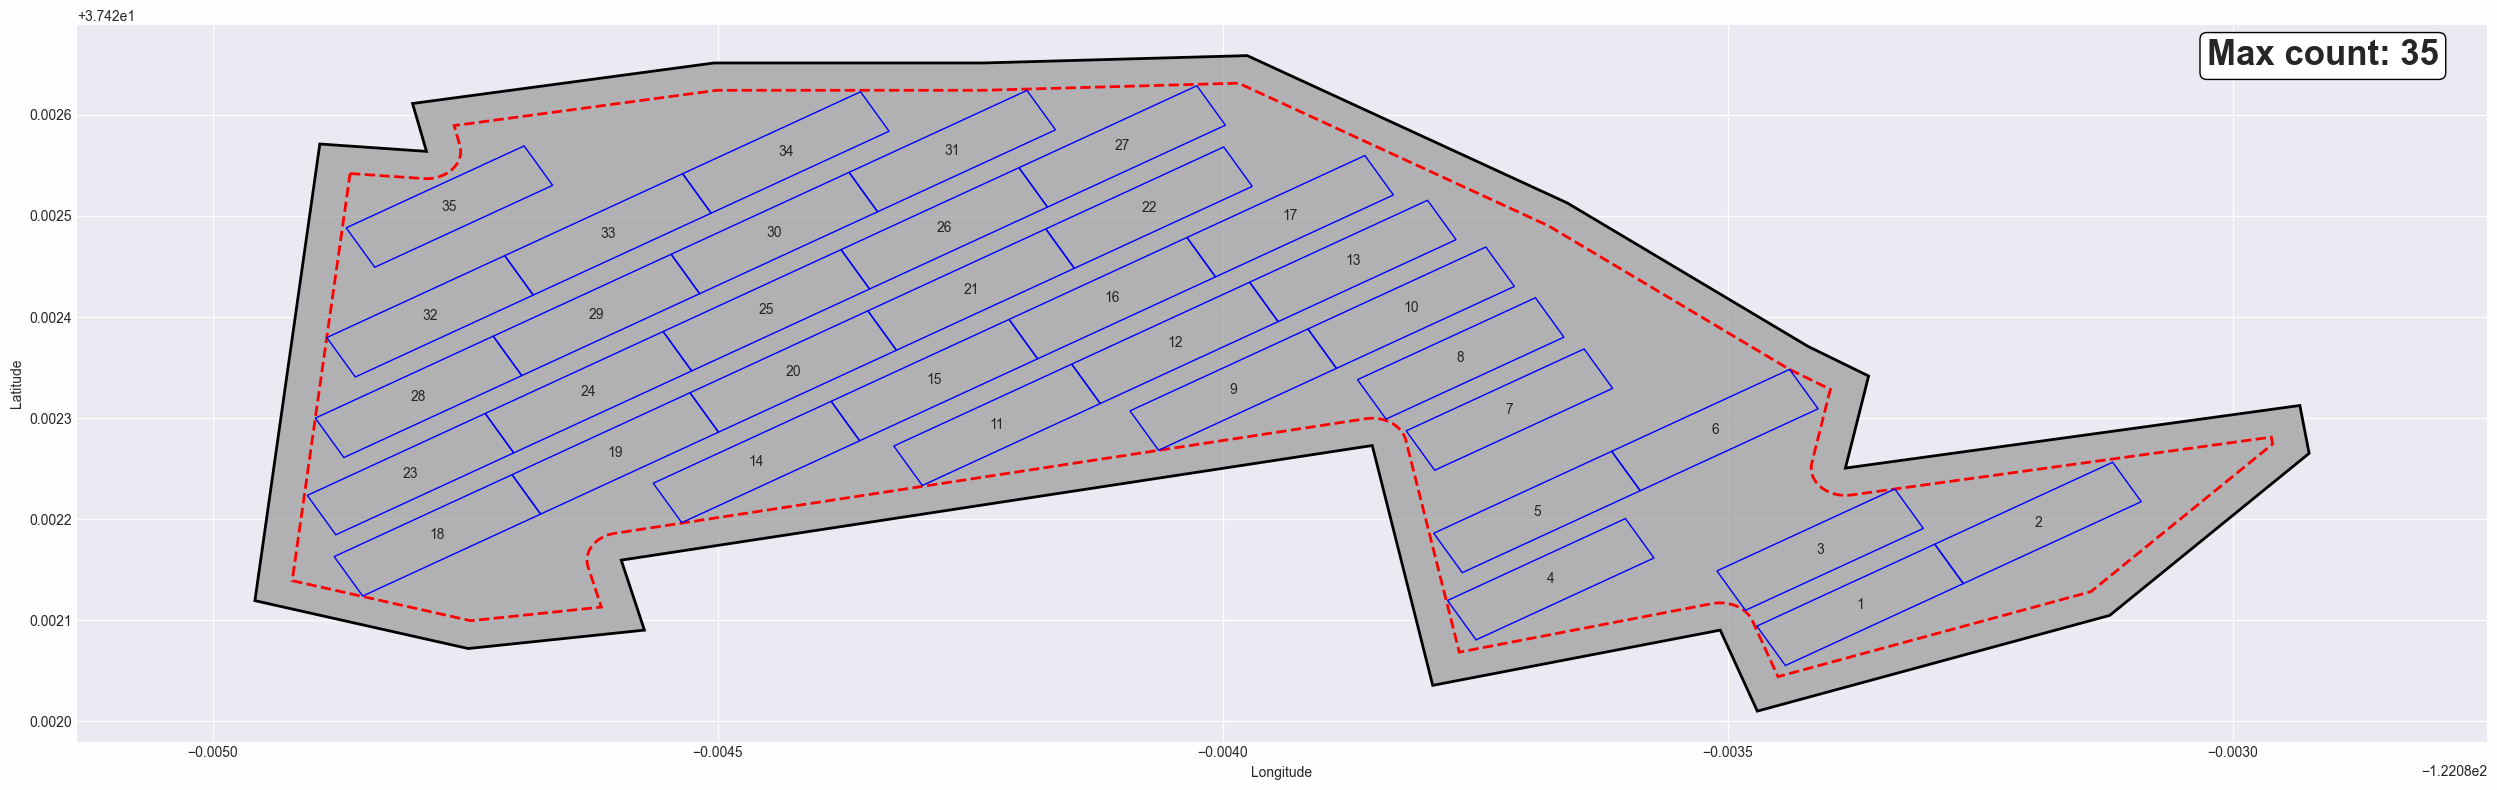

In [117]:
plot_matplotlib_rectangles(
    polygon_lonlat=current_polygon,
    rects_lonlat=a,
    centers=centers,
    rect_w_m=width,
    rect_h_m=height,
    max_count=b,
    bearing=0,
    pad_m=boundary_padding)

In [113]:
plot_maplibre_rectangles(
    polygon_lonlat=current_polygon,
    rects_lonlat=a,
    centers=centers,
    rect_w_m=width,
    rect_h_m=height,
    max_count=b,
    bearing=0,
    pad_m=boundary_padding)